In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from tqdm.notebook import tqdm

from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


---

# Tight-binding Model

<div>
<img src="https://i.imgur.com/6bzkqjG.png" width="400"/>
</div>

The tight-binding model is a quantum mechanical picture used to describe the conductance of electrons in solid-state materials. In this model, each atom is treated as a lattice site and the particle needs energy $\epsilon_i$ to occupy that site. The electron can tunnel from a site to its neighbors with an energy cost of $J$. The following Hamiltonian describes this model:

$$H_{\rm tb}/\hbar = \sum_i \epsilon_i Z_i + J \sum_{\langle i,j \rangle} (X_i X_j + Y_i Y_j)$$

The first term in the Hamiltonian describes the **on-site energy of each site**,

$$ \sum_i \epsilon_i Z_i $$

and the second term describes **the interaction energy between neighboring lattice sites**.

$$  J \sum_{\langle i,j \rangle} (X_i X_j + Y_i Y_j) $$

In the presence of a periodic lattice potential, the wavefunction of a given quantum particle overlaps neighboring lattice sites, leading to extended Bloch wavefunctions. In a uniform lattice, where all the site energies are equal ($\epsilon_i=0$), the electron propagation is linear in time and is described by a continuous-time quantum random walk. This is in contrast to classical diffusive transport, where the propagation is quadratically slower in time.

The system Hamiltonian allows us to determine how the quantum state evolves with time. This time evolution is governed by the Schrodinger equation:

$$ i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H |\psi(t)\rangle $$

In case of a time-independent Hamiltonian (a Hamiltonian that doesn't change with time), the solution to the Schrodinger equation will take the form below:

$$ |\psi(t)\rangle = e^{-i H t / \hbar} |\psi(0)\rangle $$

In this exercise we study the time dynamics under the tight-binding Hamiltonian, and construct a Trotterized circuit for its time evolution.

## 1. Time evolution under the tight-binding Hamiltonian

First, let's consider time evolution under the tight-binding Hamiltonian with 3 sites. Here we'll set $J=1$, and $\epsilon_i=0$ for a uniform lattice.

In [2]:
# Import Pauli operators (I, X, Y, Z)
from qiskit.opflow import I, X, Y, Z

J = 1

# tight-binding Hamiltonian
def H_tb():
    # Interactions (I is the identity matrix; X and Y are Pauli matricies; ^ is a tensor product)
    # Porducto tensorial IXX y XXI
    XXs = (I^X^X) + (X^X^I)
    # Porducto tensorial IYY y YYI
    YYs = (I^Y^Y) + (Y^Y^I)
    
    # Sum interactions
    H = J*(XXs + YYs)
    
    # Return Hamiltonian
    return H

In [3]:
# Unitary evolution under the tight-binding Hamiltonian
def U_tb(t):
    # Llamamos a la función anterior y lo guardamos como nuestro Hamiltoniano
    H = H_tb()
    # Retornamos el Hamiltoniano a través del tiempo 
    return (t * H).exp_i()

We initialize the state of our system to $|100\rangle$, and track the probabilities of the states $|100\rangle, |010\rangle, |001\rangle$. These values correspond to the probability of finding the particle on each different site of our lattice.

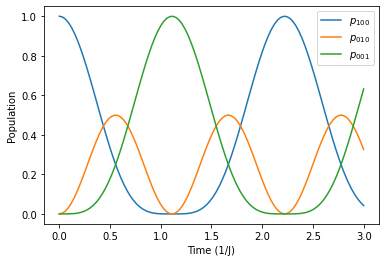

In [4]:
# Import qubit states Zero (|0>) and One (|1>)
from qiskit.opflow import Zero, One

# Define array of time points
ts = np.linspace(0, 3, 100) # DO NOT CHANGE THIS

#Devuelve números espaciados uniformemente en un intervalo específico.
#Devuelve un número de muestras espaciadas uniformemente, 
#calculadas sobre el intervalo [inicio, pasos, final].

# Producto Tensorial |100>
initial_state=One^Zero^Zero

# List Comprehension, iterando un t en el espacio temporal que almacena 
# la evolución unitaria bajo el hamiltoniano tight-binding, donde
# el @ nos sirve para realizar una composición con el estado inicial
state_t=[U_tb(float(t)) @ initial_state for t in ts]

# Obtenemos una grafica para cada estado:
# 100, 010, 001
# el adjunto ~, alterna entre una Función de Estado y una Medición
p_100= [np.abs( (~(One^Zero^Zero) @ state).eval() )**2 for state in state_t]
p_010= [np.abs( (~(Zero^One^Zero) @ state).eval() )**2 for state in state_t]
p_001= [np.abs( (~(Zero^Zero^One) @ state).eval() )**2 for state in state_t]

# Crear la grafica
plt.figure(facecolor='white')
plt.plot(ts, p_100, label=r'$p_{100}$')
plt.plot(ts, p_010, label=r'$p_{010}$')
plt.plot(ts, p_001, label=r'$p_{001}$')
plt.xlabel(r'Time (1/J)')
plt.ylabel(r'Population')
plt.legend()
plt.show()

## 2. Trotterization (Trotter-Suzuki decomposition)

To execute the unitary time evolution on a [circuit model](https://qiskit.org/documentation/apidoc/circuit.html) quantum computer, we must decompose $U_{\text{tb}}(t)$ into a product of single and two-qubit gates that are native to the quantum computer. One method to accomplish this is [Trotterization](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas), also refered to as Trotter-Suzuki decomposition. 

Below, we show an example Trotterization as outlined in \[1-2\].

Since the [Pauli operators do not commute](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) with each other, the exponential $U_{\text{tb}}(t)$ cannot be split into a product of simpler exponentials. However, we can approximate $U_{\text{tb}}(t)$ as a product of simpler exponentials through Trotterization. Consider a subsystem of 2 spin-1/2 particles within the larger 3 spin system. The Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) would be $H^{(i,j)}_{\text{tb}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. Rewritting $U_{\text{tb}}(t)$ in terms of the two possible subsystems within the total $N=3$ system you will simulate,

$$
U_{\text{tb}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right].
$$

$H^{(0,1)}_{\text{tb}}$ and $H^{(1,2)}_{\text{tb}}$ do not commute, so $U_{\text{tb}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{tb}}\right) \exp\left(-i t H^{(1,2)}_{\text{tb}} \right)$. But, this product decomposition can be approximated with Trotterization which says $U_{\text{tb}}(t)$ is approximately a short evolution of $H^{(0,1)}_{\text{tb}}$ (time = $t/n$) and followed by a short evolution of $H^{(1,2)}_{\text{tb}}$ (time = $t/n$) repeated $n$ times

$$
\begin{align}
U_{\text{tb}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right] \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n.
\end{align}
$$

$n$ **is the number of Trotter steps**, and as $n$ increases, the approximation becomes more accurate. (Note that how the unitary operator is split up into subsystems for Trotterization is not necessarily unique.) The decomposition goes further. Within each 2 spin subsystems, the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. This means we can decompose the exponential of a subsystem Hamiltonian ($H^{(i,j)}_{\text{tb}}$) into a product of even simpler exponentials getting us closer to a gate implementation of $U_{\text{tb}}(t)$

$$
\begin{align}
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} \right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} \right)\right)\right]^{n} \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \right]^{n}
\end{align}
$$

For simplicity, and to use more common notation, let's rename the products with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, and $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and rewrite the Trotterized $U_{\text{tb}}(t)$
$$
U_{\text{tb}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)}  XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)}\right]^{n}
$$
And that's it! We have now approximately decomposed $U_{\text{tb}}(t)$ into two-qubit gates $XX(t)$ and $YY(t)$. These gates are not native to superconducting qubits, but in Section 2, they will be further decomposed into native single and two-qubit gates with *further details found in the supplementary material.*


\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arxiv version](https://arxiv.org/abs/1907.03505)\]


### 2.1 Building the individual Pauli unitaries

In this section we build ZZ(t), XX(t), and YY(t) operations using single- and two-qubit gates.

In [5]:
# Definimos al parámetro de nuestra aproximación
t = Parameter('t')

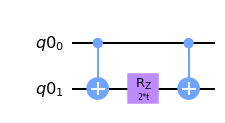

In [6]:
# Build a subcircuit for ZZ(t) from single- and two-qubit gates

# Registro de 2 qubits
ZZ_qr = QuantumRegister(2)
# Circuito usando el registro anterior y asignándole nombre de ZZ
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

# Circuito
ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

ZZ_qc.draw()

### 2.2 Clifford gates

Clifford gates are quantum operators that map Pauli operators to other Pauli operators. The Hadamard gate ($H$) and the phase gate ($S$) are examples of single-qubit Clifford gates.

$$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\1 & -1\\ \end{pmatrix}$$

$HZH^\dagger=X$, and $HXH^\dagger=Z$. Since the Hadamard gate is a Hermitian operator, $H=H^\dagger$.

$$S=\begin{pmatrix} 1 & 0 \\0 & i\\ \end{pmatrix}$$

$SXS^\dagger=Y$, and $SYS^\dagger=-X$.

Using the Clifford gates, we can transform the $e^{i ZZ t}$ to $e^{i XX t}$ and $e^{i YY t}$

<div class="alert alert-block alert-danger">
    
<b>Challenge question 1a</b> 

Build a subcircuit for XX(t) from single- and two-qubit gates
    
</div>

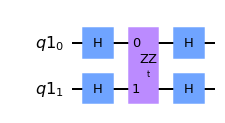

In [7]:

XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

##EDIT CODE BELOW (add Clifford operator)
XX_qc.h(0)
XX_qc.h(1)

###DO NOT EDIT BELOW

XX_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)
XX_qc.h(0)
XX_qc.h(1)
    
###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

XX_qc.draw()

**Ya tenemos lista la compuerta ZZ y también sabemos que, $HZH^\dagger=X$ y también que, $H^\dagger=H$. Por lo que simplemente agregamos 2 hadamard antes y despues del ZZ.**

In [8]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex1a

grade_ex1a(XX_qc)


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<div class="alert alert-block alert-danger">
    
<b>Challenge question 1b</b> 

Build a subcircuit for YY(t) from single- and two-qubit gates
    
</div>

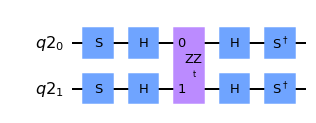

In [9]:

YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

###EDIT CODE BELOW (add Clifford operator)
for i in range(len(XX_qr)):
    YY_qc.s(i)
    YY_qc.h(i)
    
    
###DO NOT EDIT BELOW
YY_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)
for i in range(len(XX_qr)):
    YY_qc.h(i)
    YY_qc.sdg(i)
    

###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

YY_qc.draw()

**Anteriormente teníamos construida la XX a partir de la ZZ, pero sabemos que $SXS\dagger = Y$ y en este caso, $S\not=S\dagger$, por lo que utilizamos los comandos `.s` y `.sdg` respectivamente.**

In [10]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex1b

grade_ex1b(YY_qc)


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 2.3 Building the trotterizated circuit

$X_iX_j$ and $Y_iY_j$ operators commute:

$$[X_iX_j, Y_iY_j]= X_iX_j.Y_iY_j - Y_iY_j.X_iX_j = Z_iZ_j-(-Z_i)(-Z_j)=0$$

Therefore, we can decompose $e^{i t (X_iX_j + Y_iY_j)}$ as $e^{i t X_iX_j} e^{i t Y_iY_j}$. Furthermore, if $i\neq j \neq k \neq l $, then $[X_iX_j,X_kX_l]=0$. **Based on this, we can decompose each trotterized evolution time step to two blocks**:

$$U(\Delta t) \approx \Big(\prod_{i \in \rm{odd}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big)  \Big(\prod_{i \in \rm{even}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big)$$

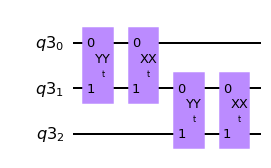

In [11]:
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

Trot_qc.draw()

<div class="alert alert-block alert-danger">
    
<b>Challenge question 1c</b> 

Create the trotterized circuit and output the unitary associated with the circuit
    
</div>

In [16]:

def U_trotterize(t_target, trotter_steps):
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    ###EDIT CODE BELOW (Create the trotterized circuit with various number of trotter steps)
    for i in range(trotter_steps):
        for j in range(0, num_qubits - 1):
            qc.append(YY, [qr[j], qr[j+1]])
            qc.append(XX, [qr[j], qr[j+1]])
    
    ###DO NOT EDIT BELOW
        
    qc = qc.bind_parameters({t: t_target/trotter_steps})
    
    return qi.Operator(qc)

  0%|          | 0/50 [00:00<?, ?it/s]

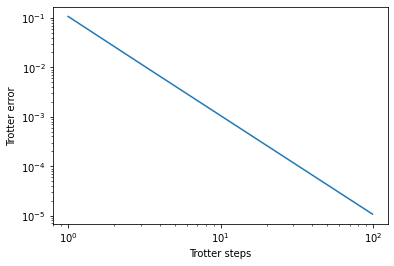

In [17]:
t_target = 0.5
U_target = U_tb(t_target)

steps=np.arange(1,101,2)  ## DO NOT EDIT

fidelities=[]
for n in tqdm(steps):
    U_trotter = U_trotterize(t_target, trotter_steps=n)
    fidelity = qi.process_fidelity(U_trotter, target=U_target)
    fidelities.append(fidelity)

plt.figure(facecolor='white')
plt.loglog(steps, 1-np.array(fidelities))
plt.ylabel('Trotter error')
plt.xlabel('Trotter steps')
plt.show()

In [18]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex1c

grade_ex1c(fidelities)


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


---